# Выбор локации для скважины

**Цель:** добывающей компании «ГлавРосГосНефть» нужно решить, где бурить новую скважину.

В моём распоряжении пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Для анализа возможной прибыли и рисков будет использована техника *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**План:**
1. Подготовка данных
2. Обучение и проверка модели
3. Подготовка к расчёту прибыли
4. Расчёт прибыли и рисков

## Загрузка и подготовка данных

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [3]:
data_0 = pd.read_csv('8_0.csv')
data_1 = pd.read_csv('8_1.csv')
data_2 = pd.read_csv('8_2.csv')

In [6]:
data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [7]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [8]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Итак, мы имеем 3 дата фрейма с одинаковой структурой. В каждом 10000 записей, 5 столбцов, из которых 1 категориальный и 4 числовых. Столбец *product* - целевой признак, столбцы *f0*, *f1*, *f2* - признаки, использующиеся для предсказания. Столбец *id* в предсказании никакой роли не играет, поэтому его можно будет удалить. Так как все 3 дата фрейма идентичны, то создадим отдельную функцию предобработки датасетов, чтобы не повторять одни и те же действия. Какие манипуляции необходимо провести над данными? 

1. *Кодирование* - единственный категориальный признак оказался бесполезным и принято решение от него избавиться, поэтому кодировать в данных нечего
2. *Заполнение пропусков* - в данных нет пропусков
3. *Проверка на выбросы* - необходимо будет проверить данные на выбросы и обработать их
4. Необходимо провести *масштабирование* данных - его будем делать после разделения данных на выборки
5. Необходимо провести *проверку на корреляцию* признаков
6. *Отбор наиболее важных признаков* - в условии задачи указано, что все признаки оказывают сильное влияние на предсказания

**1.1 Удаление лишних признаков**

In [9]:
#удаление лишнего столбца 
data_0_clean = data_0.drop('id', axis=1)   
data_1_clean = data_1.drop('id', axis=1)  
data_2_clean = data_2.drop('id', axis=1)   

**1.2 Обработка выбросов**

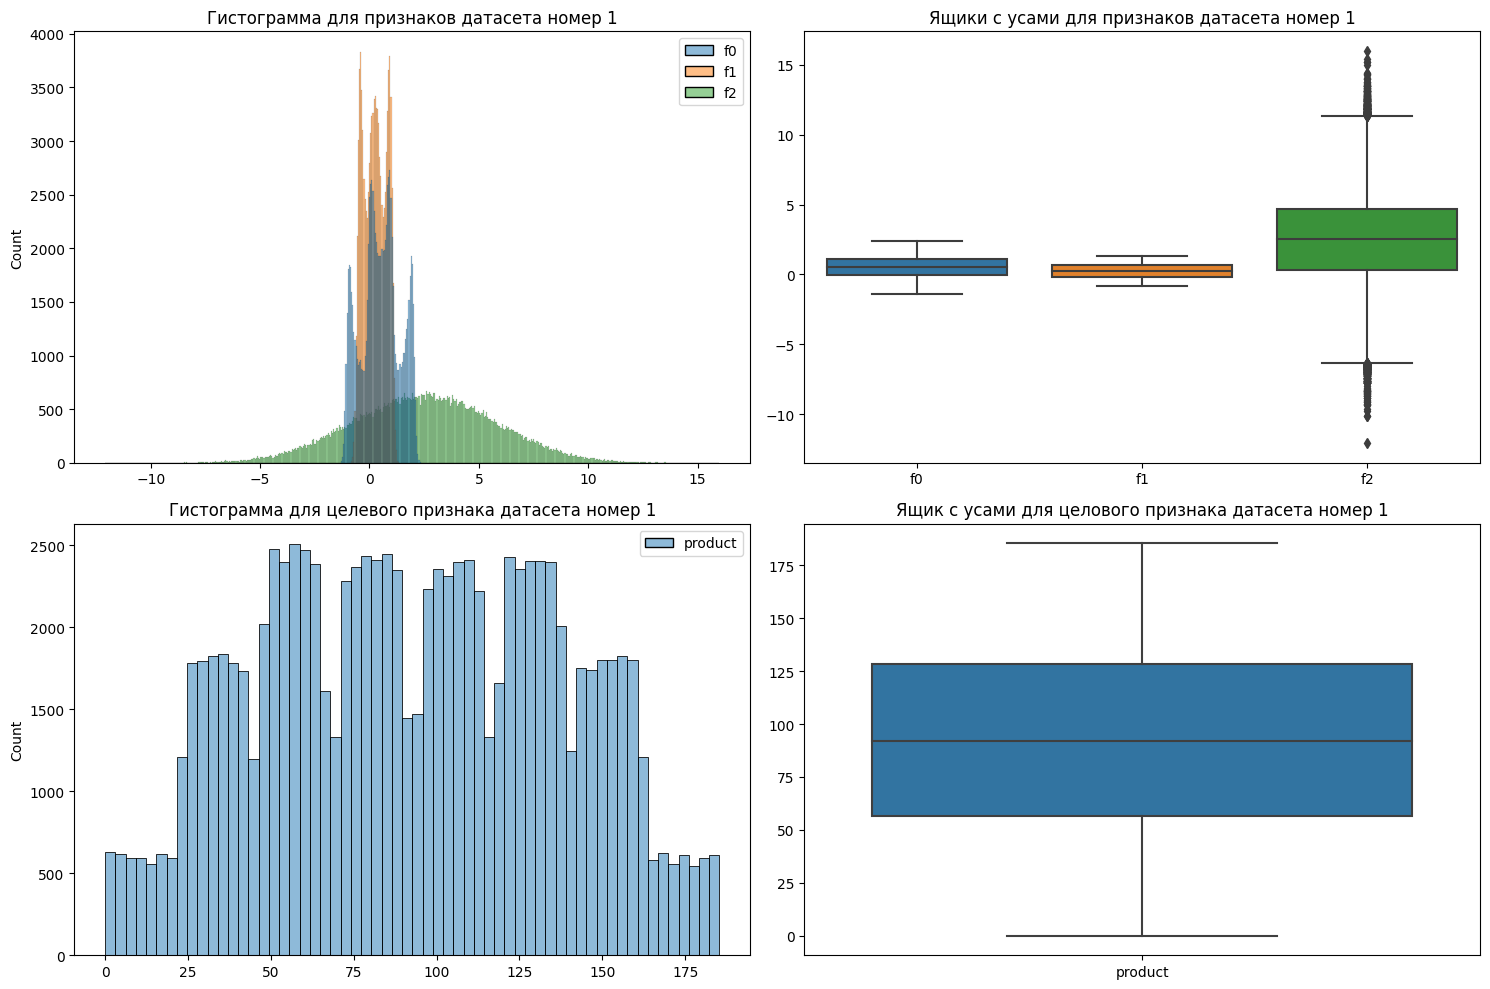

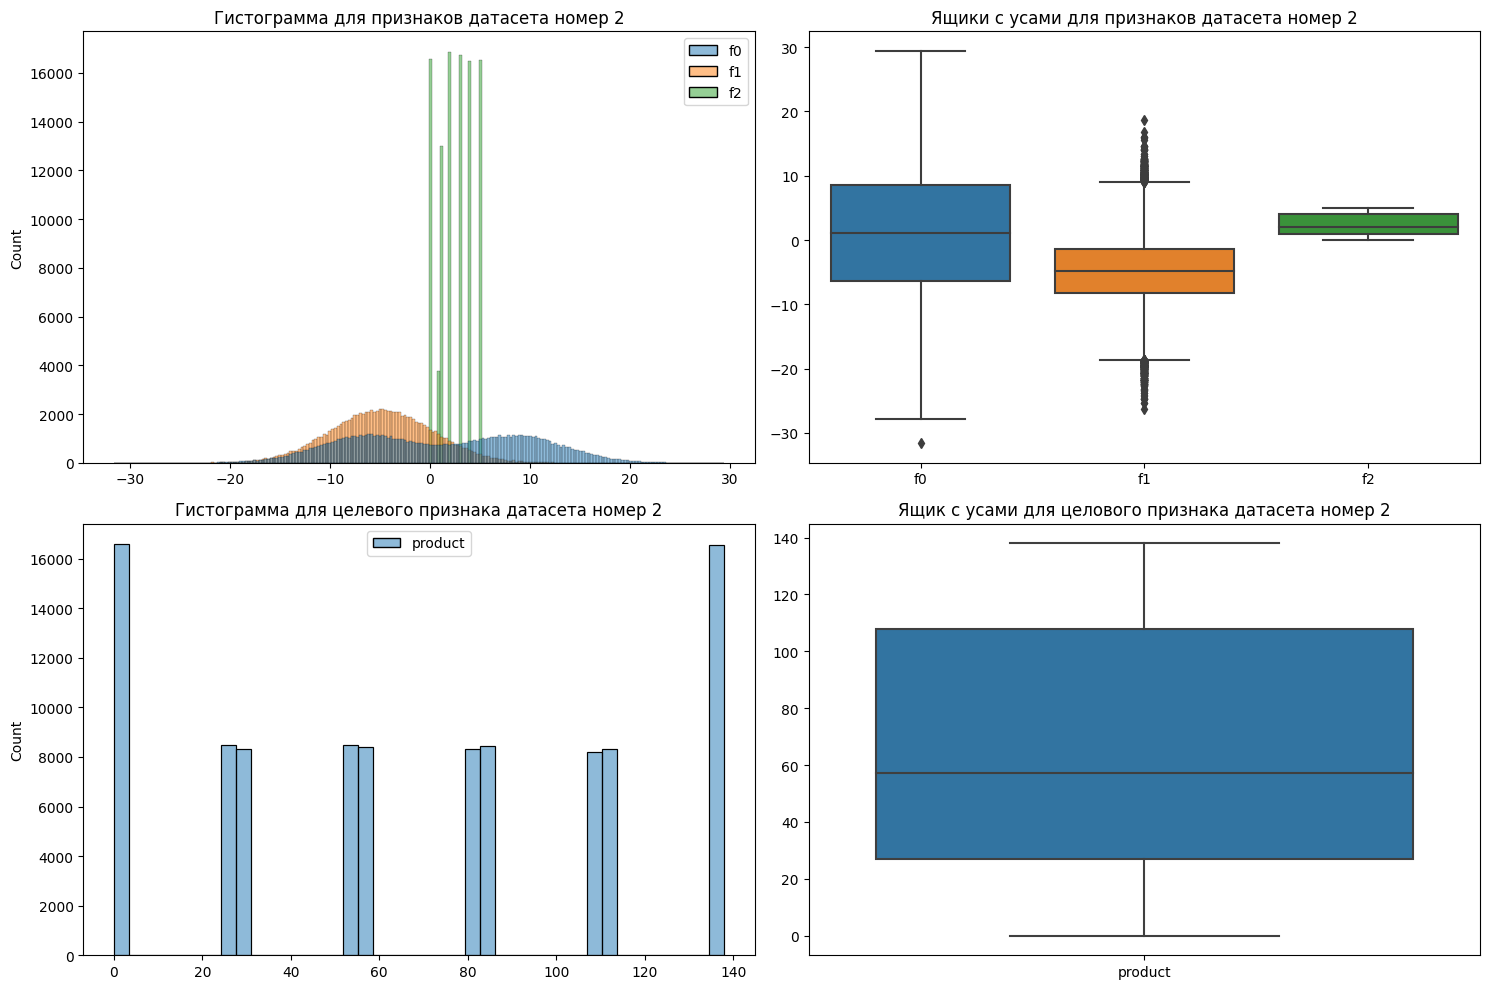

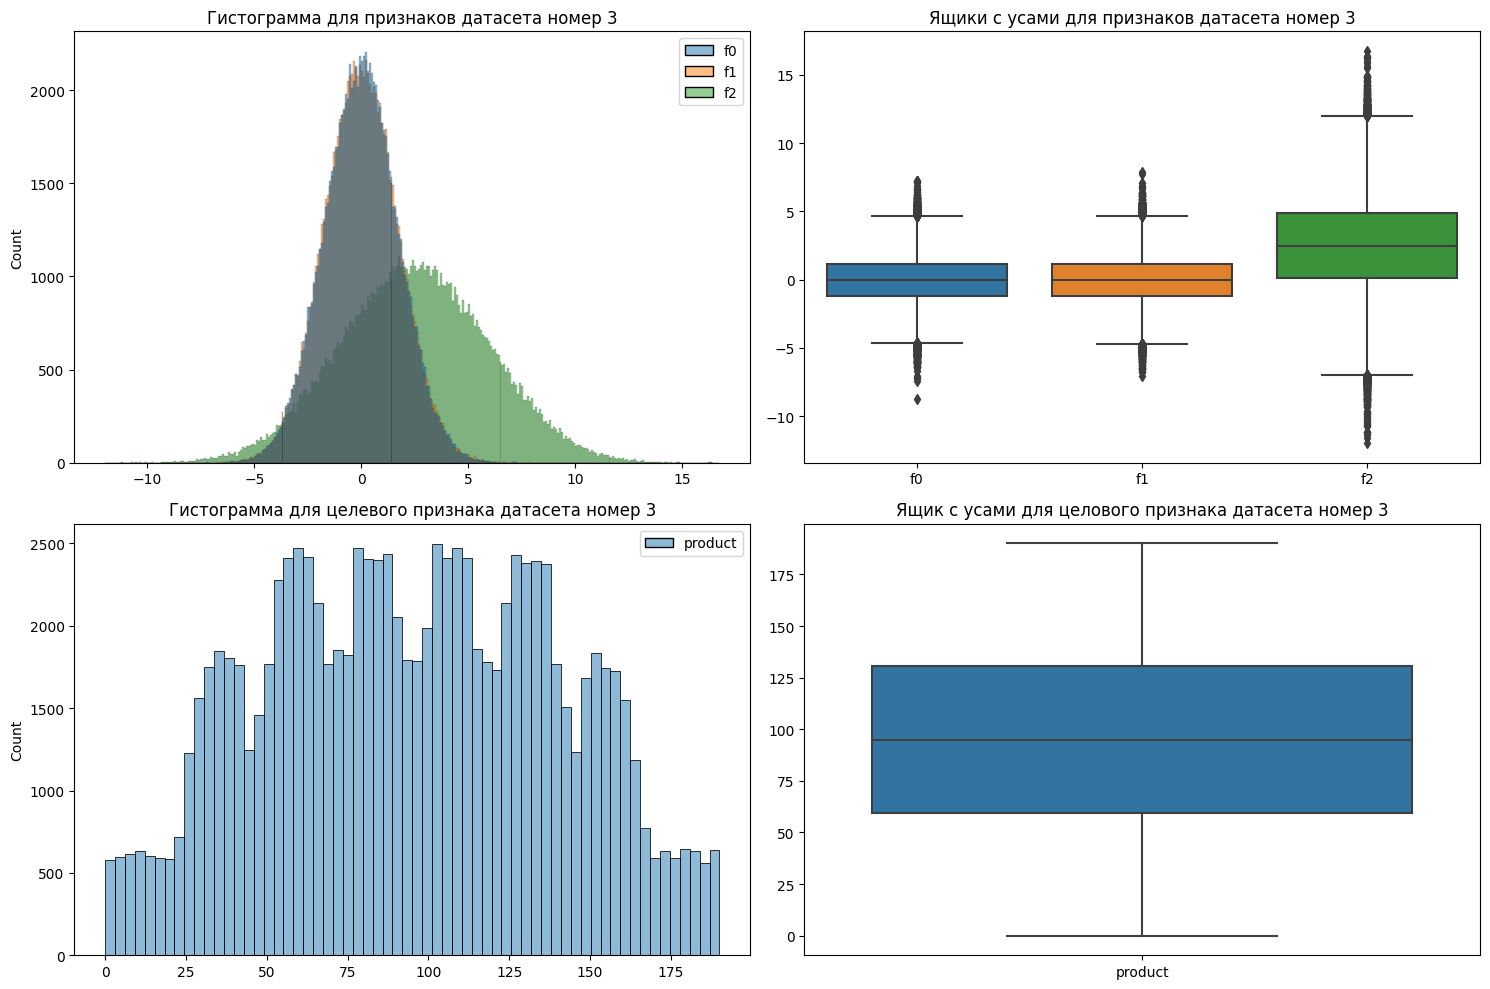

In [10]:
c = 0
for i in [data_0_clean, data_1_clean, data_2_clean]:
    c += 1
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
    sns.boxplot(data=i[['f0', 'f1', 'f2']], ax=axes[0][1]).title.set_text('Ящики с усами для признаков датасета номер ' + str(c))
    sns.histplot(data=i[['f0', 'f1', 'f2']], ax=axes[0][0]).title.set_text('Гистограмма для признаков датасета номер ' + str(c))
    sns.boxplot(data=i[['product']], ax=axes[1][1]).title.set_text('Ящик с усами для целового признака датасета номер ' + str(c))
    sns.histplot(data=i[['product']], ax=axes[1][0]).title.set_text('Гистограмма для целевого признака датасета номер ' + str(c))
    plt.tight_layout()

**Выводы по графикам:**

Датасет 1. Здесь распределение признаков отличается от распределений в датасетах 2 и 3. Ящик с усами говорит о выбросах в колонке *f2*. С целевым признаком всё хорошо, выбросов нет.

Датасет 2. Выбросы в столбце *f1*. Целевой признак распределен странно, однако выбросов нет.

Датасет 3. Все признаки распределены нормально, при этом признаки *f1* и *f2* почти точно совпадают. Выбросы есть во всех признаках. Распределение целевого признака почти нормальное. Выбросов нет.

**1.3 Проверка на корреляцию признаков**

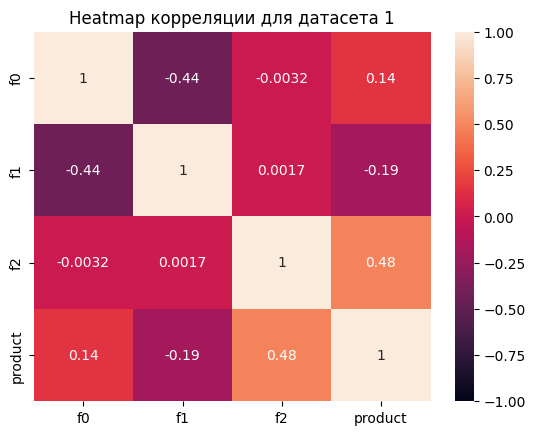

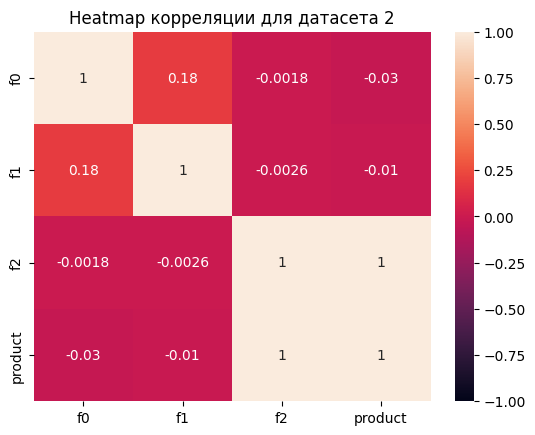

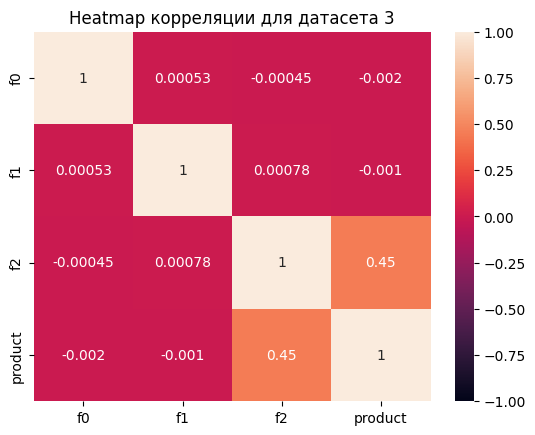

In [12]:
k = 0
for i in [data_0_clean, data_1_clean, data_2_clean]:
    k += 1
    plt.figure()
    sns.heatmap(i.corr(), vmin=-1, vmax=1, annot=True).set(title='Heatmap корреляции для датасета ' + str(k))

**Вывод:**

По результатам проверки высочайшая корреляция, равная 1, выявлена между признаком *f2* и целевым признаком. Однако мы искали корреляцию между двумя признаками, а так как таковой ненайдено, то можно идти дальше.

На этом предобработка в данном разделе окончена, но остальные этапы будут проведены после разбиения данных на выборки.

## Обучение и проверка модели

**2.1 Разбиение данных на выборки**

In [13]:
def splitter(data):
    features = data.drop('product', axis=1)
    target = data['product']
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=28)
    return features_train, features_valid, target_train, target_valid

features_train_0, features_valid_0, target_train_0, target_valid_0 = splitter(data_0_clean)
features_train_1, features_valid_1, target_train_1, target_valid_1 = splitter(data_1_clean)
features_train_2, features_valid_2, target_train_2, target_valid_2 = splitter(data_2_clean)

**2.2 Масштабирование**

In [14]:
for data in [[features_train_0, features_valid_0], [features_train_1, features_valid_1], [features_train_2, features_valid_2]]:
    scaler = StandardScaler()
    scaler.fit(data[0])
    data[0] = scaler.transform(data[0])
    data[1] = scaler.transform(data[1])

**2.3 Обучение модели**

In [15]:
def fitting(features_train, features_valid, target_train, target_valid):
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    print('Средние запасы нефти для датасета номер ' + str(k) + ':', predictions.mean())
    print('RMSE для датасета номер ' + str(k) + ':', mean_squared_error(target_valid, predictions)**0.5)
    print()
    return pd.DataFrame({'prediction': predictions, 'reality': target_valid})

preds_targ = {}
k = 0
for i in [[features_train_0, features_valid_0, target_train_0, target_valid_0], [features_train_1, features_valid_1, target_train_1, target_valid_1], [features_train_2, features_valid_2, target_train_2, target_valid_2]]:
    k += 1
    preds_targ[k] = fitting(*i)


    

Средние запасы нефти для датасета номер 1: 92.43841916872472
RMSE для датасета номер 1: 37.70262411816397

Средние запасы нефти для датасета номер 2: 68.6760913370382
RMSE для датасета номер 2: 0.8908837384313703

Средние запасы нефти для датасета номер 3: 94.69547057914866
RMSE для датасета номер 3: 40.00018582543074



**Вывод**

Средние запасы нефти в регионах 1 и 3 оцениваются в 92 - 95 тысяч баррелей, но при этом RMSE равна 40 тысячам баррелей, то есть ошибка практически в половину, что очень много. Регион 2 очень порадовал: средние запасы оцениваются всего в 70 тысяч баррелей, но при этом RMSE всего 0.89 тысяч баррелей - допустимая ошибка.

<div class="alert alert-block alert-success">
<b>Успех:</b> Модели обучены корректно. Радует, что ты активно используешь циклы. Это помогает избежать дублирования кода, а значит уменьшает вероятность совершить ошибку/опечатку!
</div>

## Подготовка к расчёту прибыли

**3.1 Константы**

In [16]:
NUM_RESEARCH = 500
NUM_DEVELOP = 200
BUDGET = 10000000000
PRICE = 450000
PROB = 0.025

**3.2 Расчёт сырья**

На разработку 200 скважин в одном регионе выделяется 10 млрд рублей. Значит на разработку одной скважины выделяется 10 млрд / 200 = 50 млн рублей. Так как одна единица продукта приносит нам 450 тысяч рублей, то нам необходимо 50 млн / 450 тысяч, т.е. 111 единиц продукта, или же 111 тысяч баррелей с одной скважины, чтобы выйти в безубыток.

Сравним полученное значение со средними по регионам. В первом регионе средние запасы были оценены в 92.38 единиц продукта, что не слишком далеко от 111, которые необходимы для безубытка. В 3 регионе ситуация еще лучше: тут запасы оцениваются в 95 единиц. А вот во 2 регионе дела обстоят плохо, запасы оценены в скромные 68 единиц. 

**Вывод**

Определено, что для выхода в безубыток необходимо обеспечить добычу 111 единиц продукта с одной скважины. Ни в одном регионе среднее значение не дотянуло до 111 единиц, однако ближайшим оказался 3 регион, где среднее количество продукта в скважине равно 95 единиц.

## Расчёт прибыли и рисков 

In [20]:
def calc_money(data):  
    data_pred_real = data.sort_values(by = 'prediction', ascending=False).reset_index().loc[:NUM_DEVELOP-1]
    return PRICE*sum(data_pred_real['reality']) - 10000000000

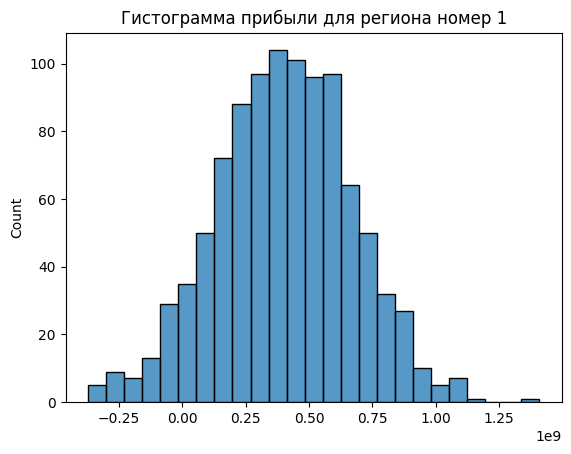

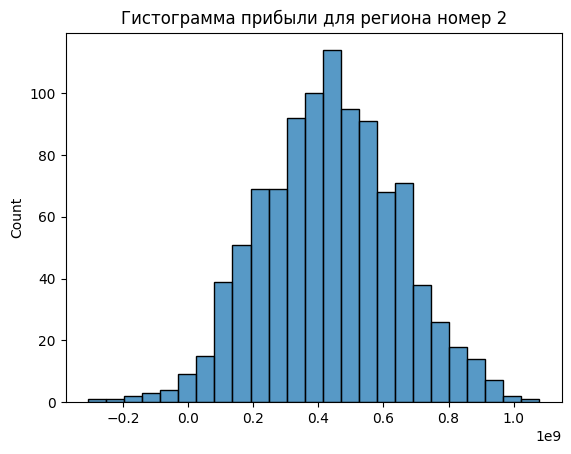

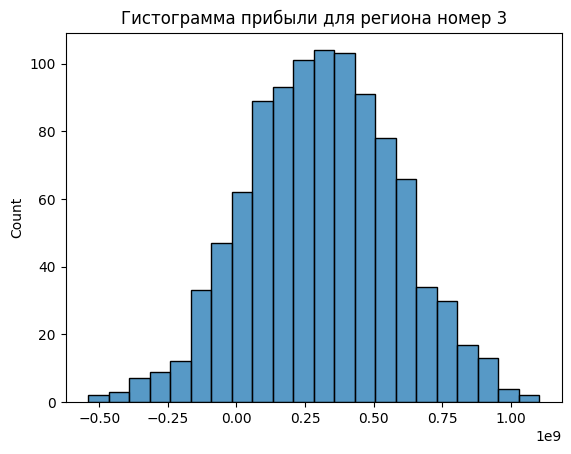

In [21]:
def mean_money(j):    
    state = np.random.RandomState(12345)
    values = []
    for i in range(1000):
        subsample = preds_targ[j].sample(n=500, replace=True, random_state=state).reset_index()
        values.append(calc_money(subsample))

    values = pd.Series(values)
    
    return values

mean_prices = []
intervals = []
risk= []
for j in range(1, 4):
    plt.figure()
    data = mean_money(j)
    mean_prices.append(data.mean())
    intervals.append((data.quantile(0.025), data.quantile(0.975)))
    risk.append((data.values < 0).mean())
    sns.histplot(data=data).title.set_text('Гистограмма прибыли для региона номер ' + str(j))

In [22]:
for j in range(3):
    print('Регион', j + 1)
    print('Среднее:', mean_prices[j])
    print('95% доверительный интервал:', intervals[j][0], '...', intervals[j][1])
    print('Риск убытка:', risk[j]*100)
    print()    

Регион 1
Среднее: 402586638.46128637
95% доверительный интервал: -128927510.16113515 ... 903840432.3753183
Риск убытка: 6.7

Регион 2
Среднее: 435738726.2582975
95% доверительный интервал: 47272778.313455686 ... 855114881.2868862
Риск убытка: 1.7000000000000002

Регион 3
Среднее: 312085478.7365632
95% доверительный интервал: -213468810.90096292 ... 852159569.9106683
Риск убытка: 12.7



**Вывод**

Единственный регион, где риск убытков меньше 2,5 процентов - регион 2. Среднее значение прибыли - 435,7 миллиона рублей. С вероятность в 95% полученная прибуль будет лежать в диапазоне от 472 миллионов рублей до 855 миллионов рублей. Регион 2 - самый благоприятный регион для разработки.

Регионы 1 и 3 показали слишком высокую вероятность убытка, при этом средняя прибыль в этих регионах меньше, чем в регионе 2.

Выбранный регион для разработки - регион 2.